In [ ]:
!pip install finta gym gym_anytrading stable_baselines3 sb3_contrib pandas_datareader yfinance

In [13]:
import csv
import time

# Data libraries
import pandas_datareader as data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA

# Gym libraries
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Reinforcement learning libraries
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib import RecurrentPPO

In [14]:
num_epochs = 10
num_timesteps = 100_000
learning_rate = 0.001

# frame_bound = (>= window size, <=len(data))


# Collect the data

In [15]:
def get_data(dates, ticker=None):
    # read the data from yahoo finance API (yfinance)
    try: 
      panel_data = data.DataReader(ticker, "yahoo", dates[0], dates[1]).reset_index()
    except:
      panel_data = yf.Ticker(ticker)
      panel_data = panel_data.history(start=dates[0], end=dates[1]).reset_index()
    # df = pd.read_csv("gmedata.csv")

    # Define date as datetime
    panel_data["Date"] = pd.to_datetime(panel_data["Date"]).dt.date

    # Sort the dates in ascending order 
    panel_data.sort_values('Date', ascending=True, inplace=True)

    # Set index
    panel_data.set_index("Date", inplace=True)

    panel_data = panel_data[["High", "Low", "Open", "Close", "Volume"]]

    return panel_data

In [16]:
# S&P 500 data
ticker = "^GSPC"
df = get_data(ticker=ticker, dates=["2000-01-01", "2022-12-1"])

In [17]:
df

,High,Low,Open,Close,Volume
Date,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000
...,...,...,...,...,...
2022-11-25,4034.020020,4020.760010,4023.340088,4026.120117,1706460000
2022-11-28,4012.270020,3955.770020,4005.360107,3963.939941,3615430000
2022-11-29,3976.770020,3937.649902,3964.189941,3957.629883,3546040000


# Split the data

In [18]:
def split_data(df):
    
    df_train = df[(df.index < sorted(df.index.values)[-int(0.2*len(sorted(df.index.values)))])]
    df_test = df[(df.index >= sorted(df.index.values)[-int(0.2*len(sorted(df.index.values)))])]
    
    return df_train, df_test

In [19]:
df_train, df_test = split_data(df)

In [20]:
def data_separated_plot(train_data: pd.DataFrame, test_data: pd.DataFrame):

    fig = plt.figure(figsize=(15, 12))
    st = fig.suptitle("Data Separation", fontsize=20)
    st.set_y(0.95)

    ax1 = fig.add_subplot(211)
    ax1.plot(train_data.index, train_data["Close"], label='Training data')
    ax1.plot(test_data.index, test_data["Close"], label='Test data')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Closing Returns')
    ax1.set_title("Close Price", fontsize=18)
    ax1.legend(loc="best", fontsize=12)
    ax1.grid(linestyle="--")

    ax2 = fig.add_subplot(212)
    ax2.plot(train_data.index, train_data["Volume"], label='Training data')
    ax2.plot(test_data.index, test_data["Volume"], label='Test data')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Normalized Volume Changes')
    ax2.set_title("Volume", fontsize=18)
    ax2.legend(loc="best", fontsize=12)
    ax2.grid(linestyle="--")

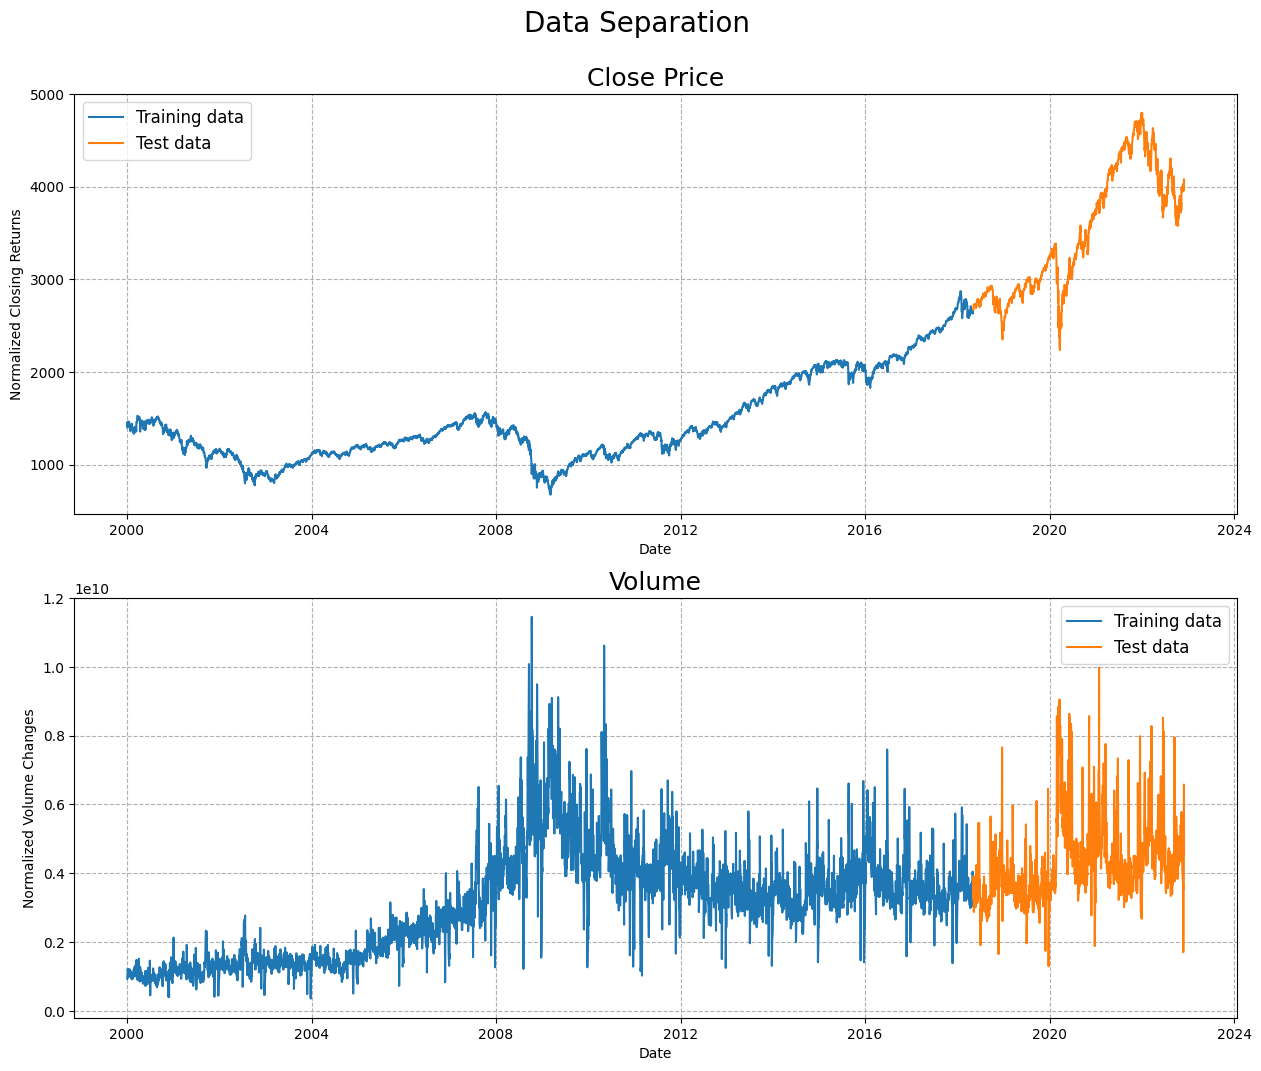

In [21]:
data_separated_plot(train_data=df_train, test_data=df_test)

# Environment Creation

In [30]:
env = gym.make(id="stocks-v0", df=df_test, frame_bound=(128, len(df_test)), window_size=128)

## Testing the environment

# Train the model

In [24]:
env_maker = lambda: gym.make(id="stocks-v0", df=df_train, frame_bound=(128, len(df_train)), window_size=128)
env = DummyVecEnv([env_maker])

explain variance as high as possible, close to one
value loss as low as possible

Num epochs: 10
info {'total_reward': 24.380126953125, 'total_profit': 0.9922668681577075, 'position': 0}
Num epochs: 20
info {'total_reward': 750.78955078125, 'total_profit': 0.038964903383007614, 'position': 0}
Num epochs: 30
info {'total_reward': 240.56982421875, 'total_profit': 0.03927774171411456, 'position': 1}
Num epochs: 40
info {'total_reward': 1478.1611328125, 'total_profit': 0.8710958312541912, 'position': 1}
Num epochs: 50
info {'total_reward': 338.78125, 'total_profit': 0.16237476717764754, 'position': 0}
Num epochs: 60
info {'total_reward': 54.068603515625, 'total_profit': 0.050250708331976264, 'position': 1}
Num epochs: 70
info {'total_reward': -490.632080078125, 'total_profit': 0.023481550724794728, 'position': 0}
Num epochs: 80
info {'total_reward': 0.0, 'total_profit': 1.4270726642250493, 'position': 1}
Num epochs: 90
info {'total_reward': 987.770751953125, 'total_profit': 0.4617501548557813, 'position': 1}
Num epochs: 100
info {'total_reward': 678.4013671875, 'total_p

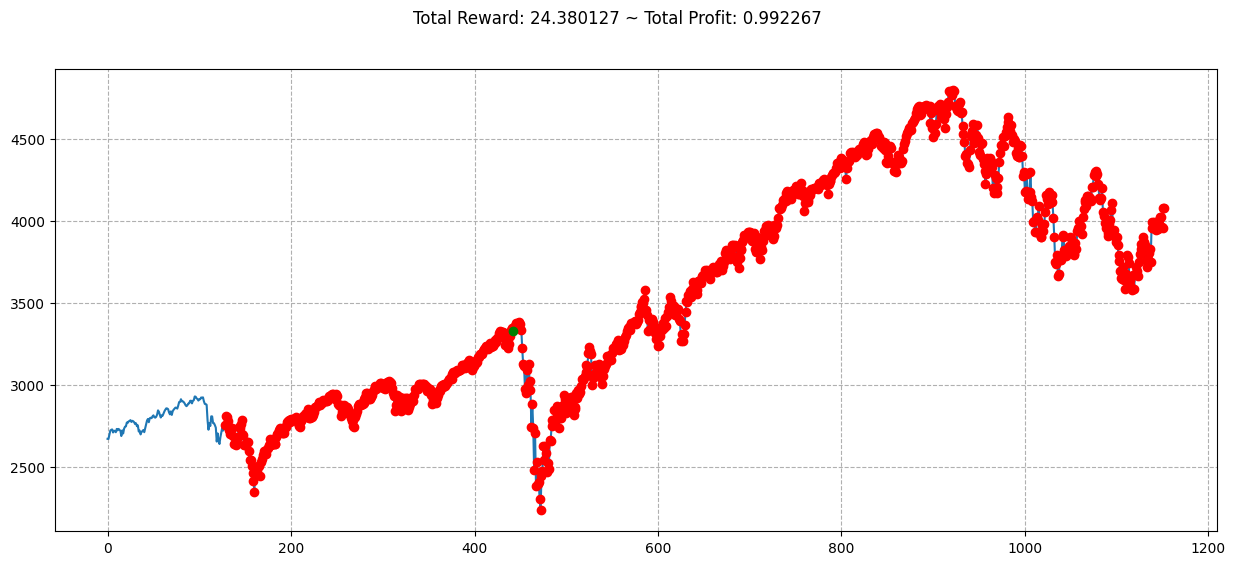

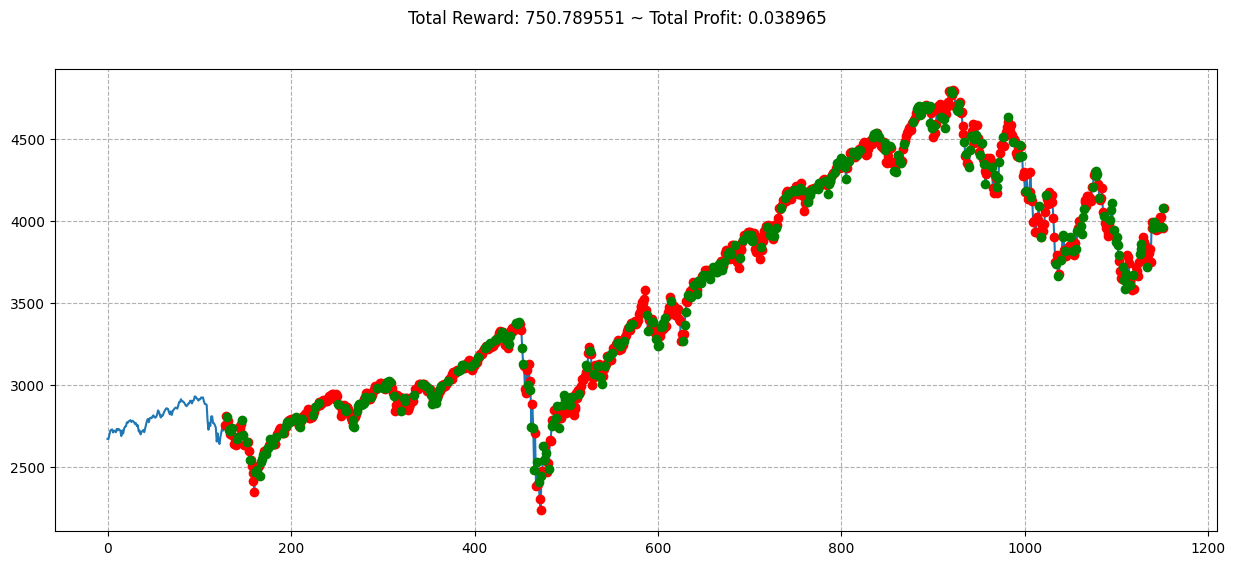

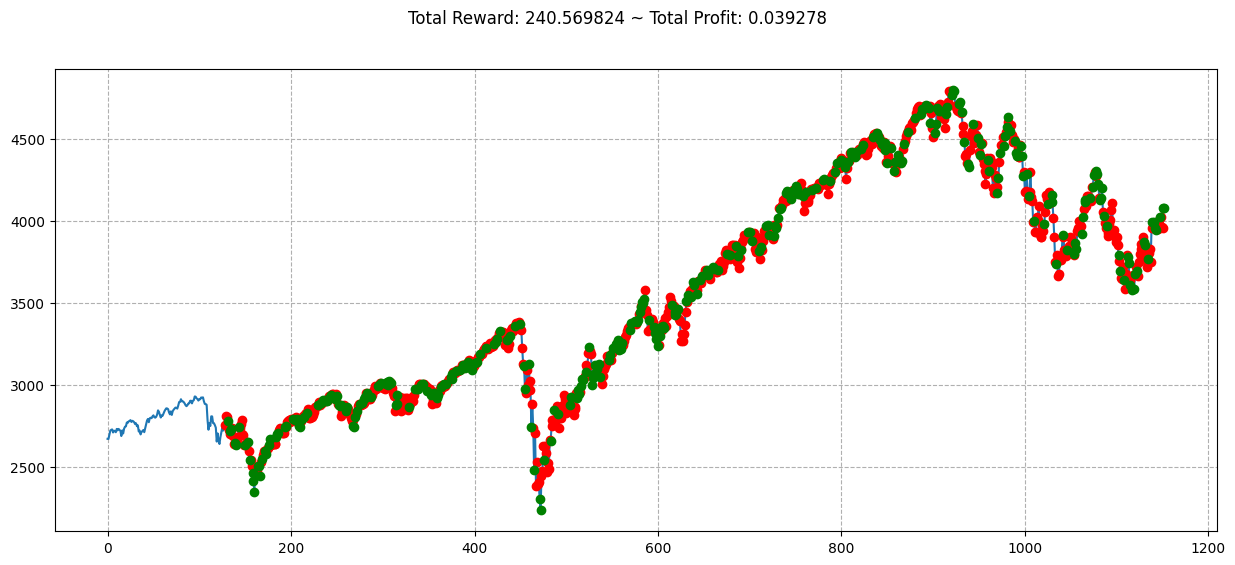

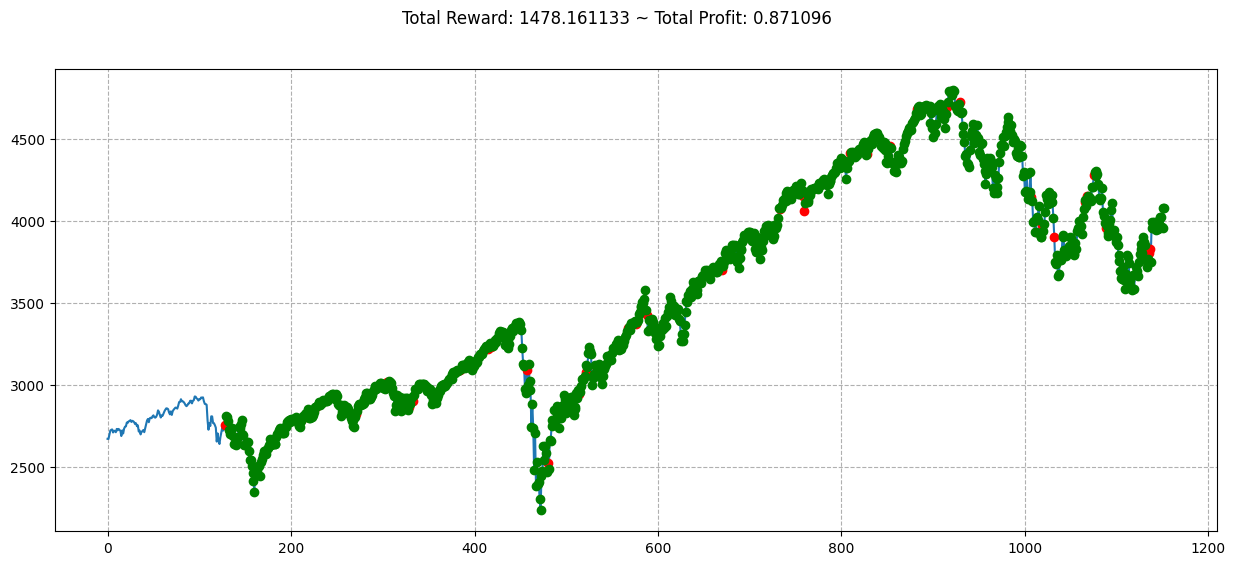

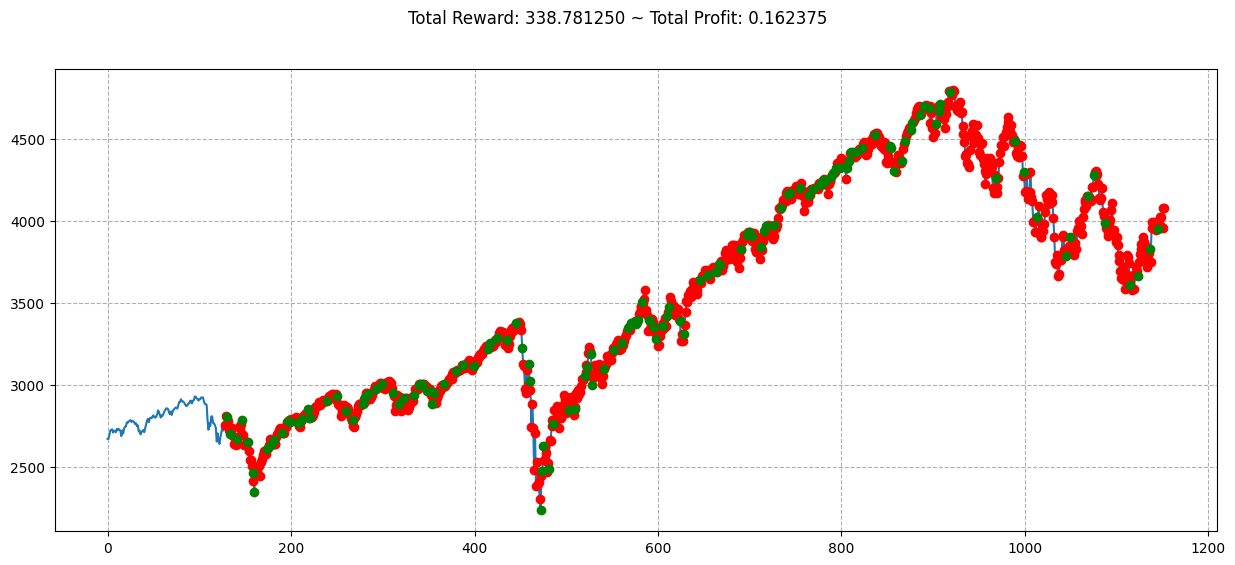

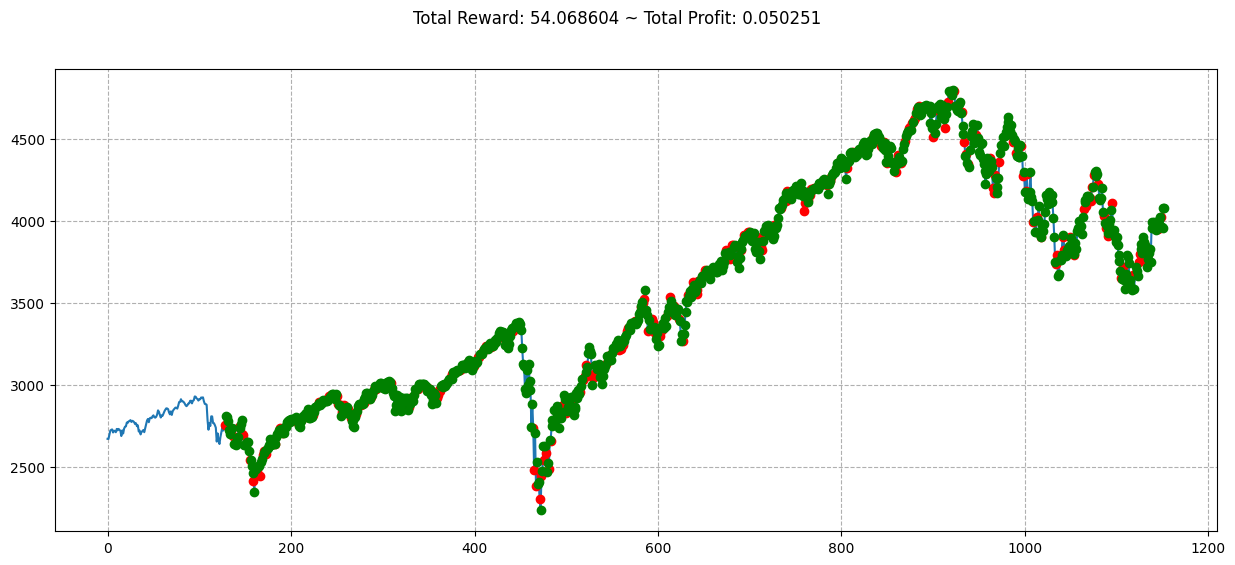

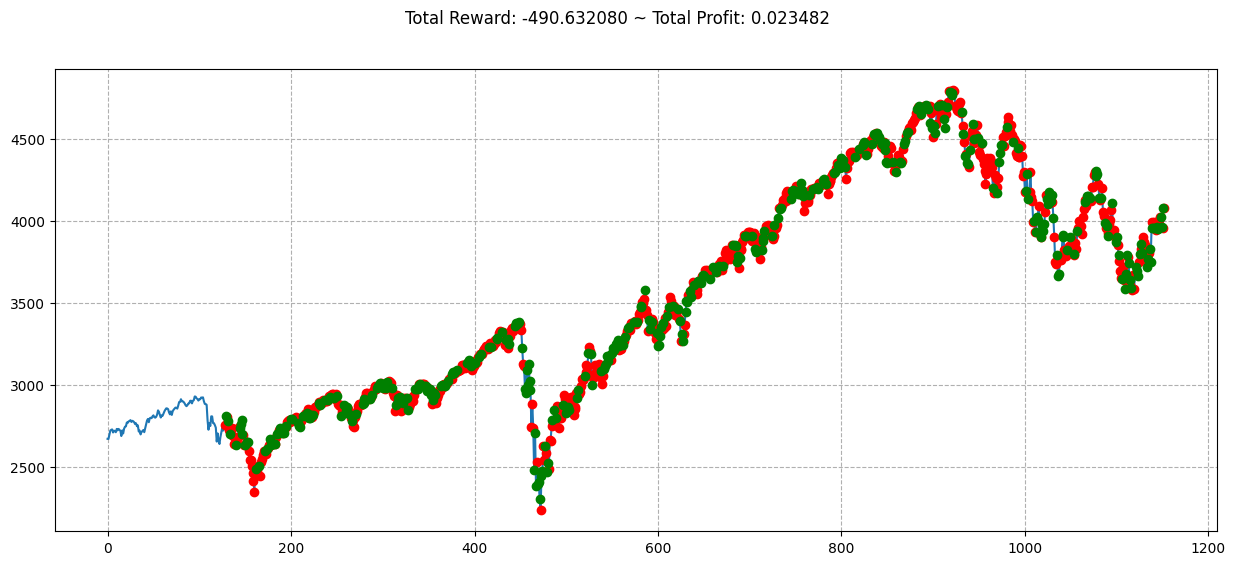

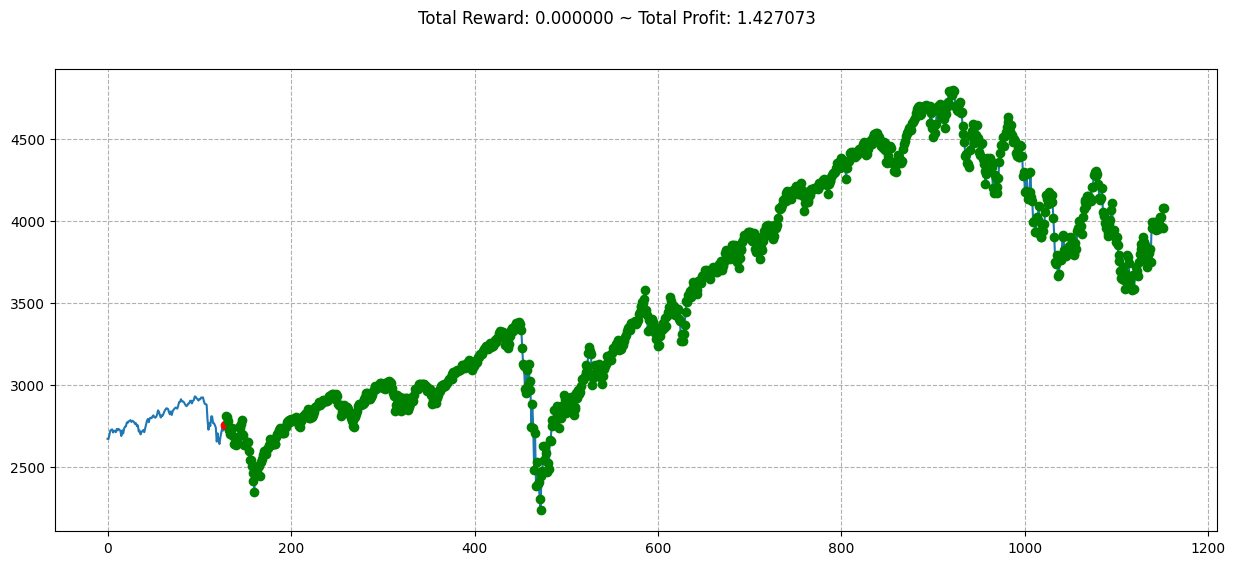

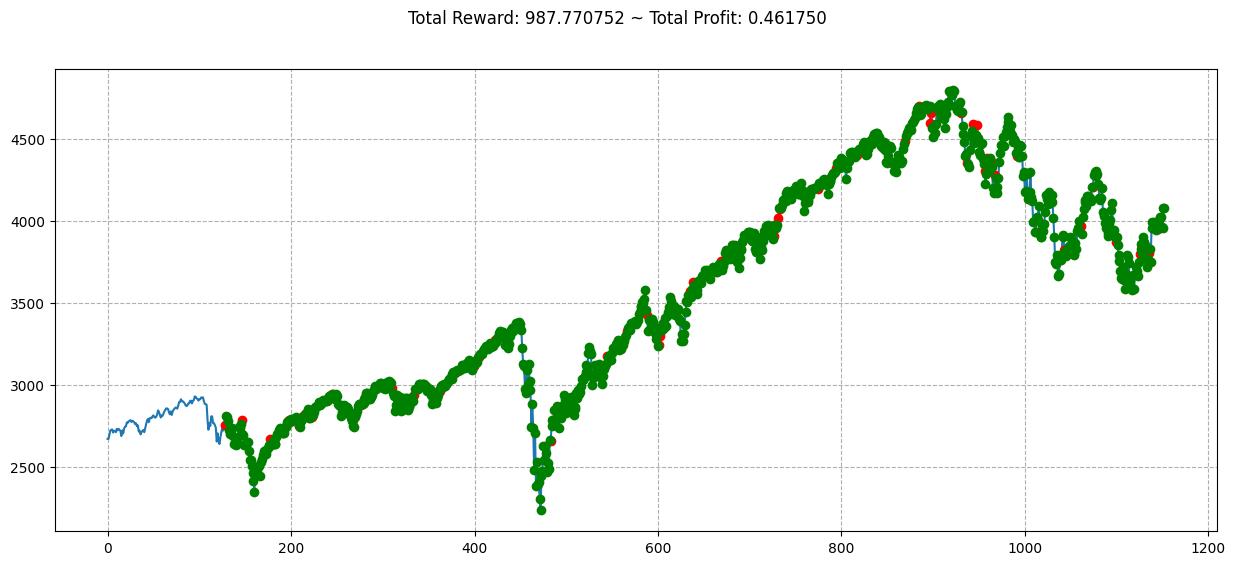

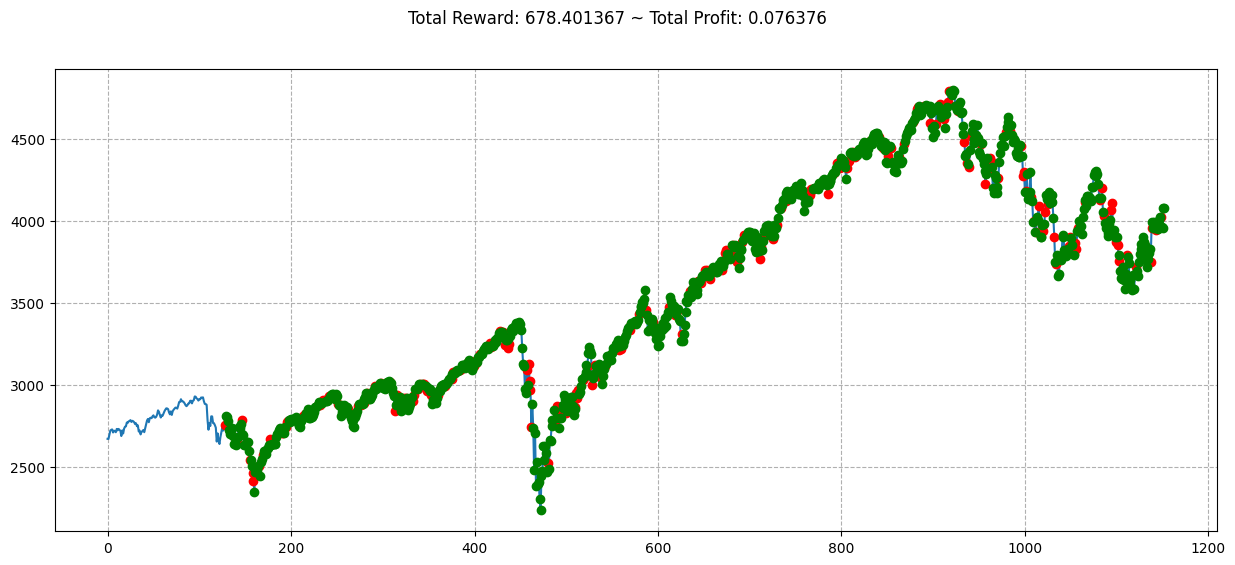

In [25]:
data = ["total_reward", "total_profit", "position", "num_epochs", "learning_rate", "num_time_steps", "time"]
with open('results/tables/results.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(data)

data_results = {
    "num_epochs": 0,
    "learning_rate": 0.001,
    "num_time_steps": 100_000
}

for epochs in range(10, 110, 10):

    start=time.time()

    data_results["num_epochs"] = epochs
    print(f"Num epochs: {epochs}")
    env_maker = lambda: gym.make(id="stocks-v0", df=df_train, frame_bound=(128, len(df_train)), window_size=128)
    env = DummyVecEnv([env_maker])
    model = RecurrentPPO(policy="MlpLstmPolicy", env=env, verbose=0, learning_rate=0.001, batch_size=64, n_epochs=epochs)
    model.learn(total_timesteps=100_000)
    # Evaluate results
    env = gym.make("stocks-v0", df=df_test, frame_bound=(128,len(df_test)), window_size=128)
    obs = env.reset()
    while True:
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action=action)
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.grid(linestyle="--")
    plt.savefig(
        fname=f"results/images/PPO_LSTM_{epochs}epochs.png", 
        dpi="figure", 
        format="png", 
        bbox_inches="tight",
        transparent=True
    )

    data_results["time"] = time.time() - start

    info.update(data_results)
    
    results = pd.DataFrame(info, index=[0])
    results.to_csv("results/tables/results.csv",mode="a", index=False, header=False)

Learning Rate: 0.0001
info {'total_reward': -527.55908203125, 'total_profit': 0.019634675633038053, 'position': 1}
Learning Rate: 0.0002
info {'total_reward': 1022.071533203125, 'total_profit': 0.03255994589411729, 'position': 1}
Learning Rate: 0.0003
info {'total_reward': 1665.902099609375, 'total_profit': 0.07949932996442136, 'position': 1}
Learning Rate: 0.0004
info {'total_reward': -187.910400390625, 'total_profit': 0.03174112262727079, 'position': 1}
Learning Rate: 0.0005
info {'total_reward': 933.599853515625, 'total_profit': 0.029801595248019695, 'position': 1}
Learning Rate: 0.0006
info {'total_reward': 834.69091796875, 'total_profit': 0.5826394898978087, 'position': 0}
Learning Rate: 0.0007
info {'total_reward': 1441.073486328125, 'total_profit': 0.17078633081978317, 'position': 1}
Learning Rate: 0.0008
info {'total_reward': 1028.343017578125, 'total_profit': 0.04858329504093254, 'position': 1}
Learning Rate: 0.0009
info {'total_reward': 1419.940673828125, 'total_profit': 0.09

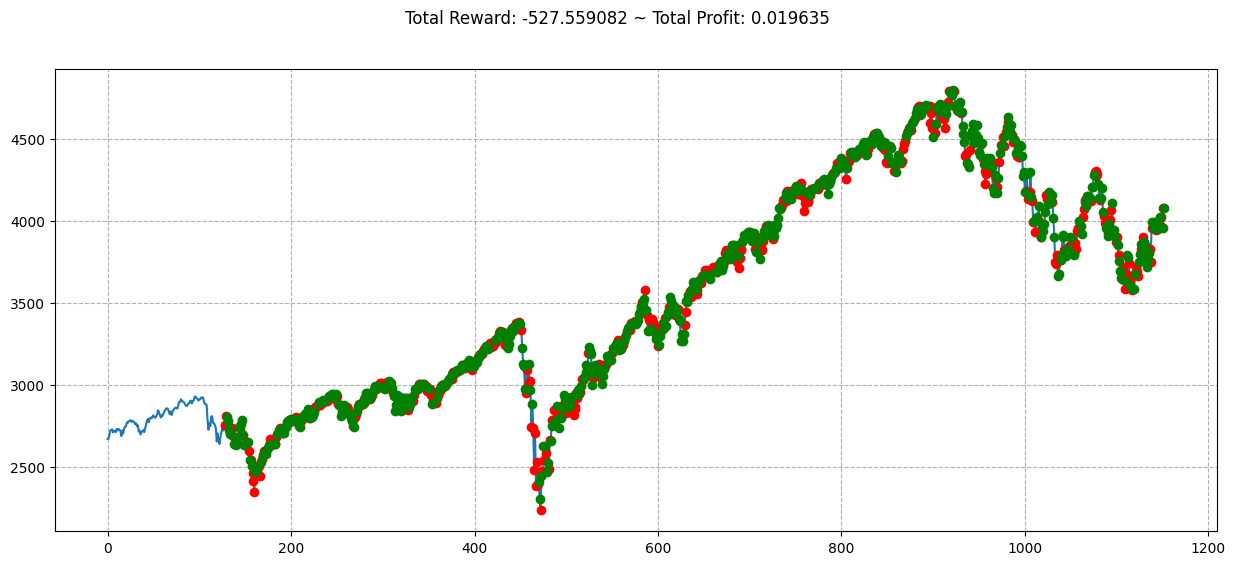

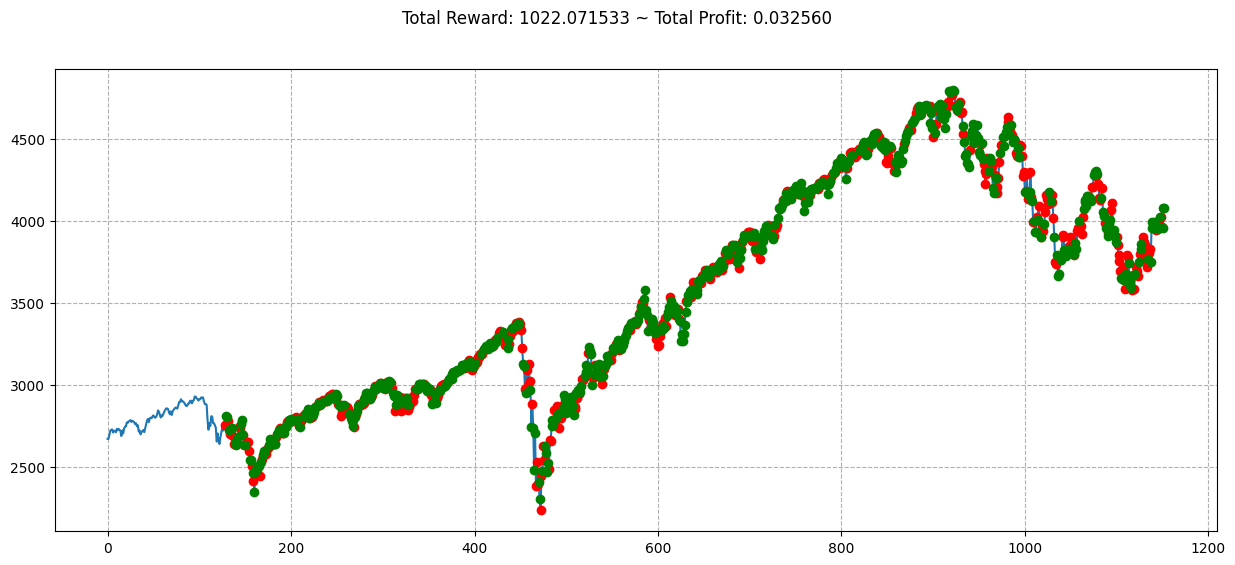

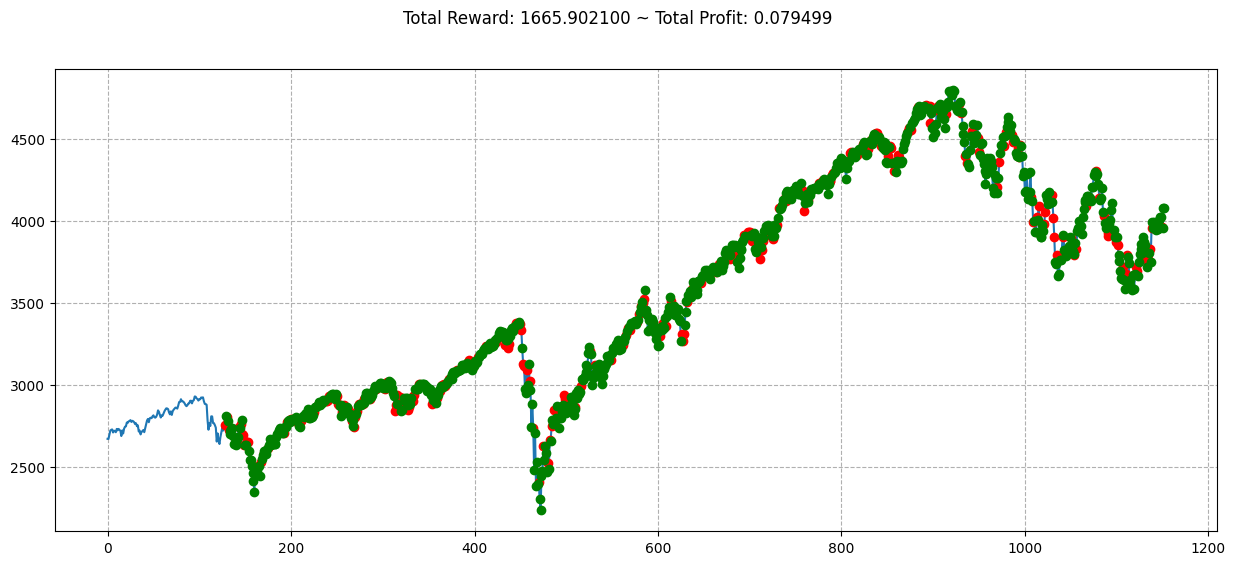

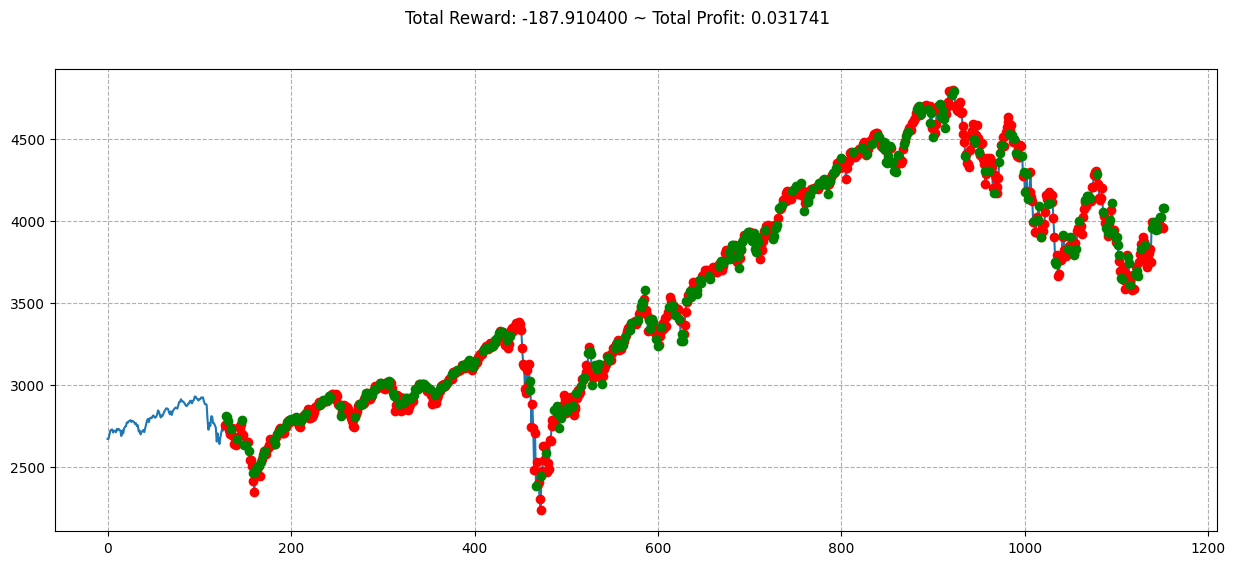

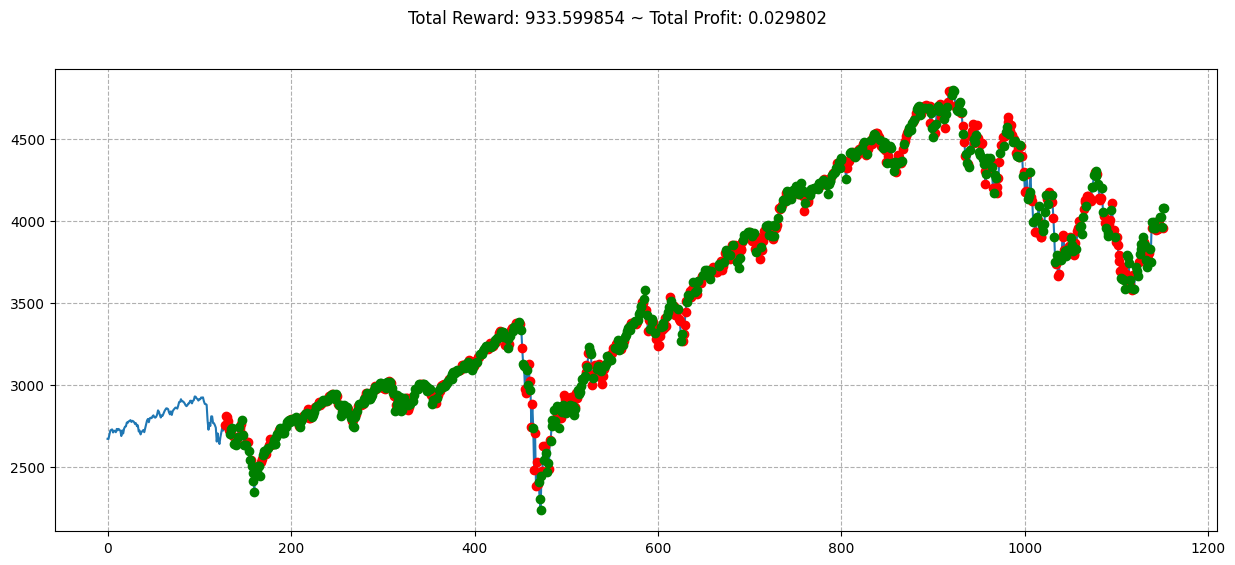

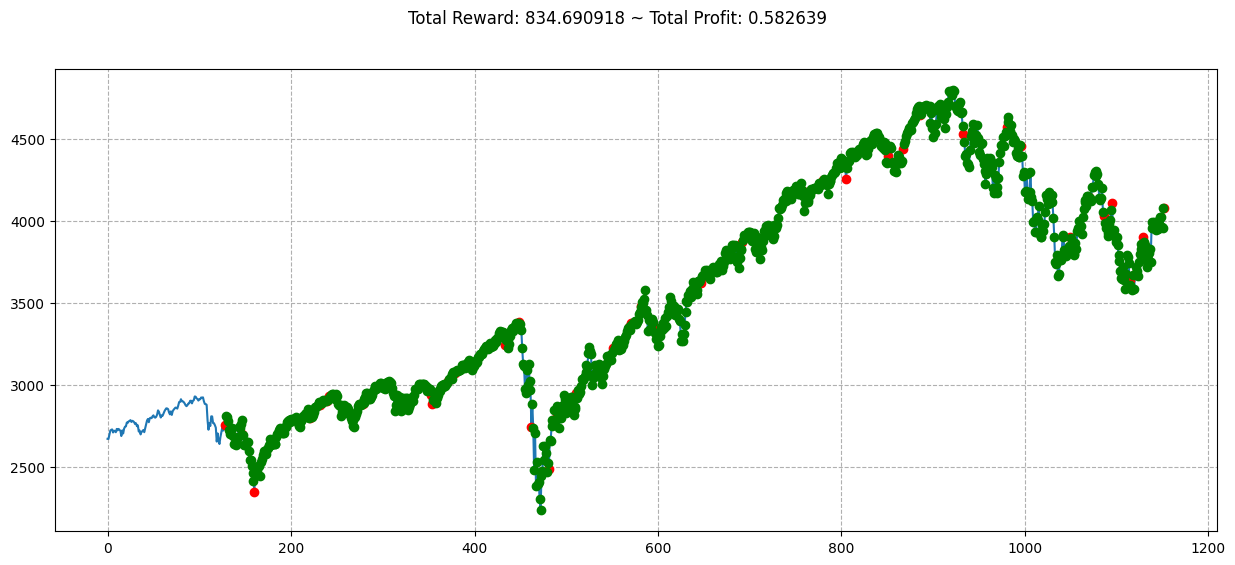

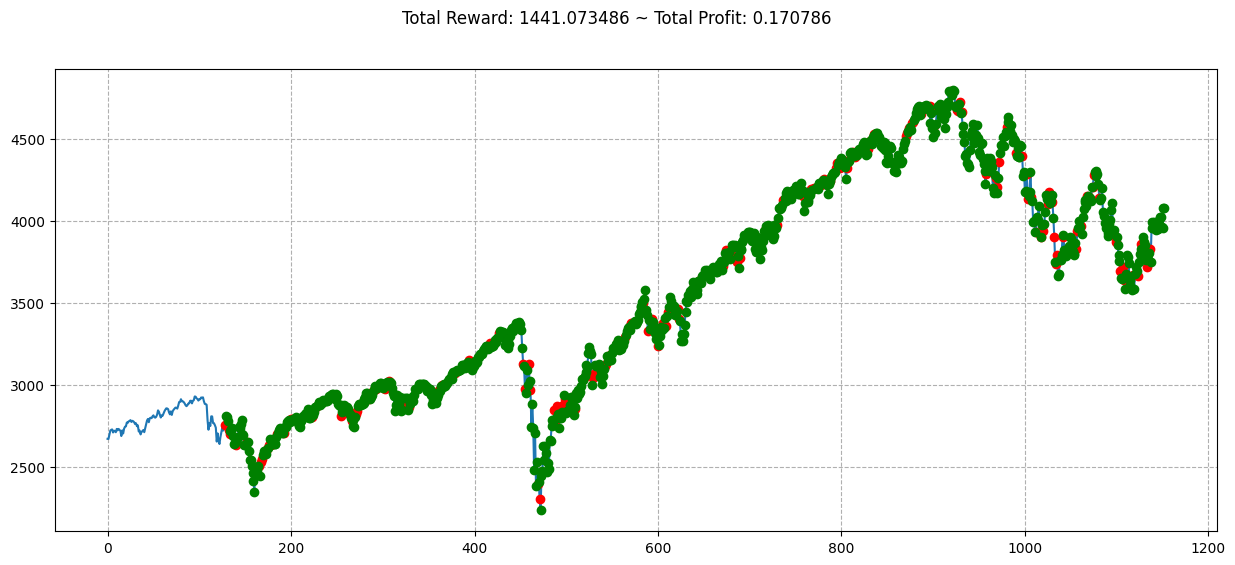

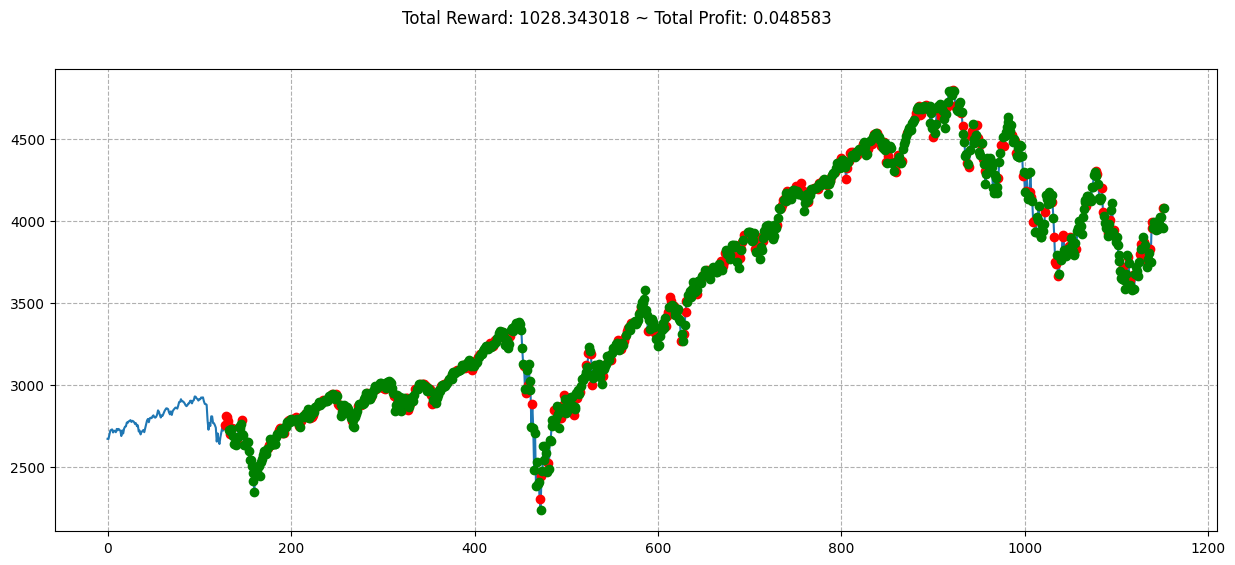

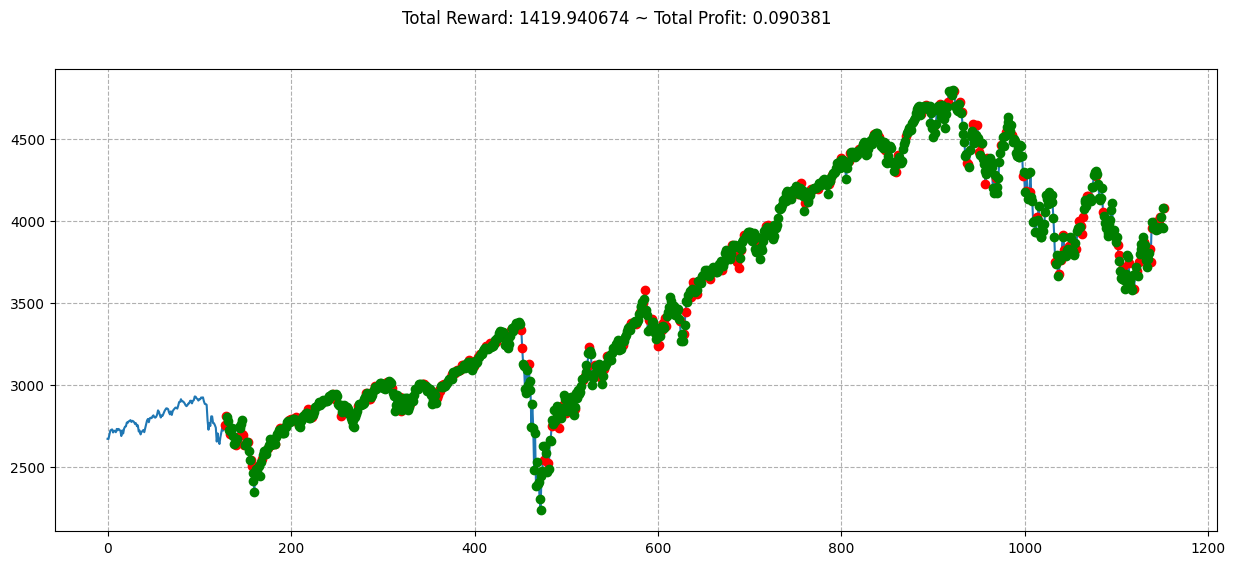

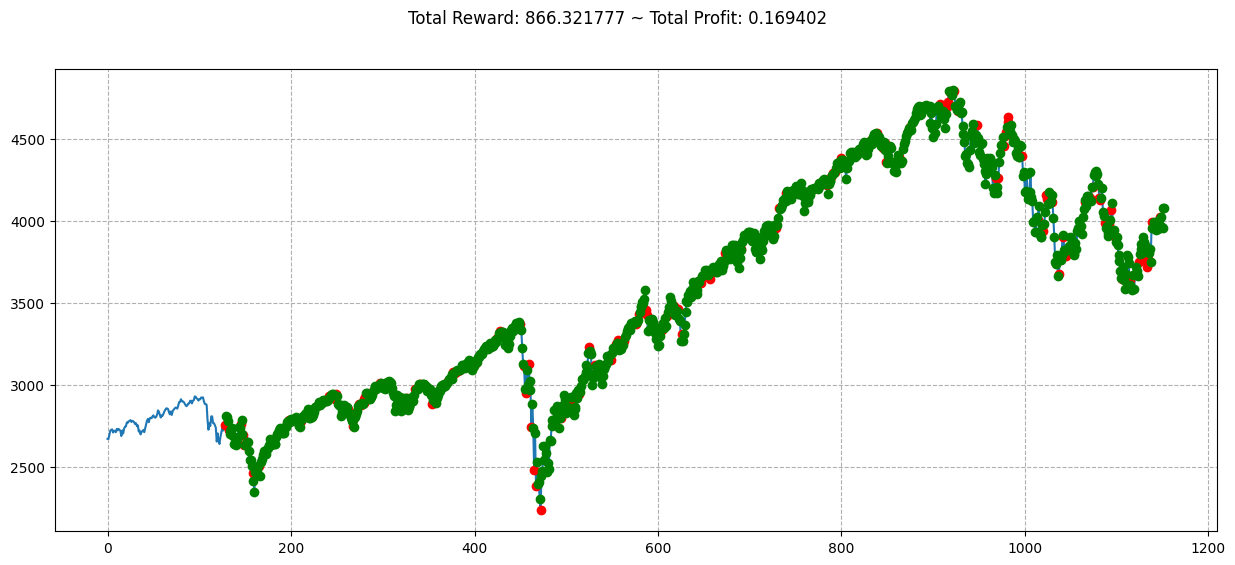

In [26]:
data = ["total_reward", "total_profit", "position", "num_epochs", "learning_rate", "num_time_steps", "time"]
with open('results/tables/results_lr.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(data)

data_results = {
    "num_epochs": 10,
    "learning_rate": 0,
    "num_time_steps": 100_000
}

for lr in range(1, 11, 1):
    lr = lr/10000
    start=time.time()
    
    data_results["learning_rate"] = lr
    print(f"Learning Rate: {lr}")
    env_maker = lambda: gym.make(id="stocks-v0", df=df_train, frame_bound=(128, len(df_train)), window_size=128)
    env = DummyVecEnv([env_maker])
    model = RecurrentPPO(policy="MlpLstmPolicy", env=env, verbose=0, learning_rate=lr, batch_size=64, n_epochs=10)
    model.learn(total_timesteps=100_000)
    # Evaluate results
    env = gym.make("stocks-v0", df=df_test, frame_bound=(128,len(df_test)), window_size=128)
    obs = env.reset()
    while True:
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action=action)
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.grid(linestyle="--")
    plt.savefig(
        fname=f"results/images/PPO_LSTM_{lr}lr.png", 
        dpi="figure", 
        format="png", 
        bbox_inches="tight",
        transparent=True
    )

    data_results["time"] = time.time() - start

    info.update(data_results)
    
    results = pd.DataFrame(info, index=[0])
    results.to_csv("results/tables/results_lr.csv",mode="a", index=False, header=False)

In [60]:
model = RecurrentPPO(policy="MlpLstmPolicy", env=env, verbose=0, learning_rate=0.001, batch_size=64, n_epochs=20)
model.learn(total_timesteps=100_000)

# Evaluation

info {'total_reward': 1662.460205078125, 'total_profit': 0.3428890621031168, 'position': 1}


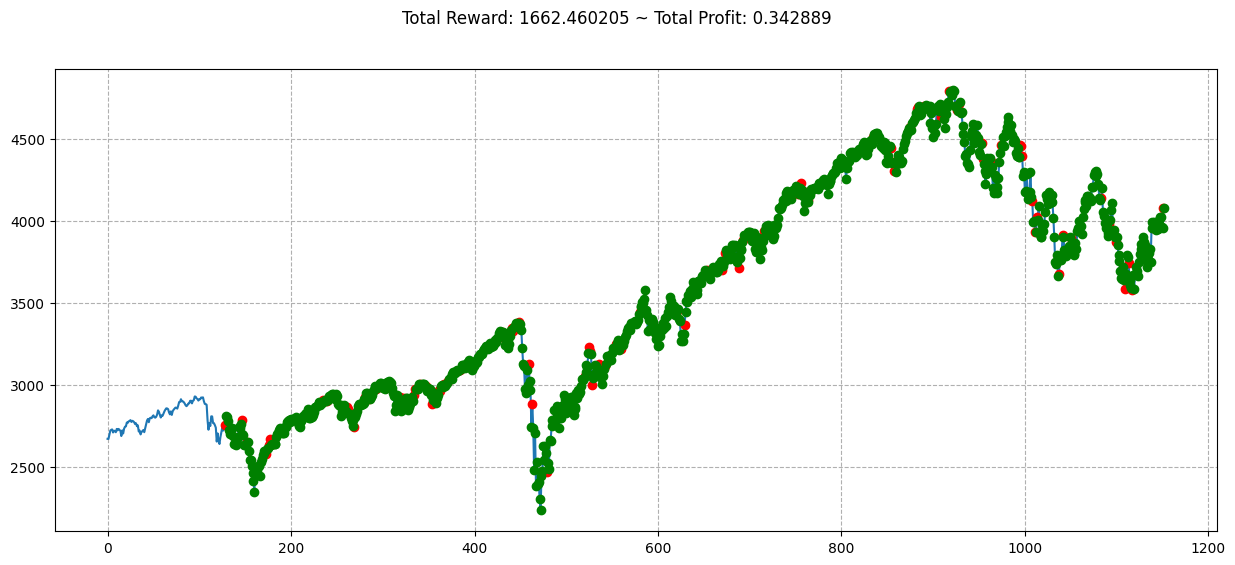

In [61]:
env = gym.make("stocks-v0", df=df_test, frame_bound=(128,len(df_test)), window_size=128)
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action=action)
    if done:
        print("info", info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.grid(linestyle="--")

In [65]:
data_results = {
    "num_epochs": 0,
    "learning_rate": 0.001,
    "num_time_steps": 100_000
}

In [66]:
info.update(data_results)

In [68]:
info.pop("data_results")

{'num_epochs': 0, 'learning_rate': 0.001, 'num_time_steps': 100000}

In [69]:
info

{'total_reward': 1662.460205078125,
 'total_profit': 0.3428890621031168,
 'position': 1,
 'num_epochs': 0,
 'learning_rate': 0.001,
 'num_time_steps': 100000}

In [70]:
results = pd.DataFrame(info, index=[0])
results

,total_reward,total_profit,position,num_epochs,learning_rate,num_time_steps
0,1662.460205,0.342889,1,0,0.001,100000


In [71]:
results.to_csv("results/tables/reuslts.csv", index=False)

1671058261.105977

In [29]:
model.get_parameters()

{'policy': OrderedDict([('mlp_extractor.policy_net.0.weight',
               tensor([[ 0.0210, -0.0205,  0.0749,  ...,  0.0847, -0.0069, -0.0422],
                       [-0.0072,  0.0500,  0.1597,  ...,  0.0890,  0.0040,  0.1469],
                       [-0.0234, -0.0097,  0.0079,  ...,  0.0566, -0.0667,  0.0611],
                       ...,
                       [-0.0681,  0.0513, -0.0466,  ..., -0.0047, -0.1352,  0.0517],
                       [ 0.0832, -0.0005,  0.0813,  ..., -0.0415,  0.0157,  0.0311],
                       [ 0.0419,  0.0361, -0.1517,  ..., -0.0088,  0.1373, -0.0963]])),
              ('mlp_extractor.policy_net.0.bias',
               tensor([ 0.0282,  0.0257,  0.0381,  0.0290,  0.0202,  0.0229,  0.0367,  0.0370,
                       -0.0238,  0.0199, -0.0175, -0.0208,  0.0278, -0.0315,  0.0242, -0.0216,
                        0.0480,  0.0352, -0.0056,  0.0005,  0.0381, -0.0330,  0.0186,  0.0321,
                        0.0318, -0.0208,  0.0145,  0.0025,  0.